# Regression Discontinuity Design Project - COVID Cases

Task: Use RDD to estimate the effect of the following events in Quebec:

- The 20/3/2020 lockdown
- The reopening of schools on 31/8/2020
- The 25/12/2020 lockdown

Requirements
Find data on at least one COVID measure for y (either COVID cases, hospitalizations or deaths) and provide the following for each:

### RDD plot
#### All three events
- Used line graphs as data used was not daily, so points were too scattered to be interpreted in a meaningful manner with a scatter plot or less linear chart

### Interpretation of the p-value of the effect of the measure taken
- Lockdown 1
    - P-value below 0.05 indicates that the lockdown had a statistically significant impact on the number of cases
        - Num Total Last 7: 0.000
        - Num Total Last 14: 0.001
        - Avg Cases Last 7: 0.000
    
- School Reopening
    - P-value of 0.00 all around indicates that the lockdown had a very statistically significant impact on the number of cases
        - Num Total Last 7: 0.000
        - Num Total Last 14: 0.000
        - Avg Cases Last 7: 0.000

- Lockdown 2
    - P-values above 0.05 for 7-day metrics but below 0.05 for 14-day metrics indicate that the lockdown did not have a
    statistically significant effect in the first week, but did have an impact in the following weeks
        - Num Total Last 7: 0.079
        - Num Total Last 14: 0.030
        - Avg Cases Last 7: 0.079

### Justification on the design of your regression:
#### All three events
- Data cleaning:
    - Removed all information not directly relevant to my analysis to avoid overfitting model and to make data easier to interpret
- Chosen data:
    - Chose COVID cases as my metric since changes in data should be easily observable and directly correlated to the chosen cutoffs
    - Chose three metrics of different significances in order to capture the effect of the cutoffs from multiple perspectives and timeframes (significance of this is observable in the p-value differences for lockdown 2)
        - Num Total Last 7: Captures short-term trends and immediate effects of events
        - Num Total Last 14: Captures trends and immediate effects of events on a more long-term basis
        - Avg Cases Last 7: Provides a smoothed representation of cases over time, showing the magnitude of changes after events

### Amount of time included on both sides of the cutoff
- Equal amount of time on both sides to more accurately track changes in trends
    - Generally aiming for around 3 months as we can see trends before and after, and long-term impacts of cutoff
    - Not longer to avoid zooming out of our cutoff and missing data

- Lockdown 1: 48 days (beginning of data to to cutoff, same length of time after)

- School Reopening:  3 months (enough time to see trends before and after cutoff, not too much to see effect of other significant events
    - Used trial and error with chart to see significant trends before and after cutoff
    
- Lockdown 2:  4 months (same justification as school reopening)
    - Used trial and error with chart to see significant trends before and after cutoff

### Polynomial degree
#### All three events
- I focused on one degree due to the linearity of my data
    - This also helped to avoid overfitting and keep my data easy to interpret

### Other regression design considerations
#### All three events
- Polynomial regression could have been good for modelling the data if the relationship was less linear

### Explanation of findings for each event.
- Lockdown 1
    - The data associated with the first lockdown on 20/3/2020 would indicate that the cutoff correlated with a significant increase in covid cases, and that the lockdown was a statistically significant factor in this (based on r-squared, p-values, and coefficients).
    - However, we can reasonably assume this to be due to bias in our data, as the overall covid cases were very low prior to the cutoff since the pandemic had just started, and since the number of cases of a highly transmittable virus are likely to increase exponentially regardless of the circumstances, we could consider the data to be unreliable and not necessarily representative of reality.

- School Reopening
    - The data associated with schools reopening on 31/8/2020 would indicate that the cutoff correlated with a significant rise in covid cases. Our OLS regression results indicate that schools reopening was a statistically significant factor in this increase, and that the fact of schools reopening accounts for a large percentage of the reason covid cases increased at all (or as much as they did).
    - Looking into the data several months before and after the cutoff shows us that the increase associated with schools reopening is likley not simply due to normal fluctuations in covid cases, as cases reported had decreased significantly in the  months prior to the cutoff, and continued to increase significantly for several months after the cutoff.

- Lockdown 2
    - Our OLS regression results for this data mostly indicate that the second lockdown was not a statistically significant factor in the change in covid cases, due to the low r-squared and high p-values. The only concrete data we obtained here is for numtotal_last14, which indicates that the lockdown statistically correlated with an increase in covid cases
    - However, looking at the data visually, we can see that a few weeks after the cutoff (around 10/1/2021), covid cases started to decrease rather significantly. This could indicate that the lockdown did have a significant impact on reducing covid cases, but that it took some time for the changes to take effect. 

### Sources
- https://open.canada.ca/data/en/dataset/261c32ab-4cfd-4f81-9dea-7b64065690dc
- https://open.canada.ca/data/en/dataset/261c32ab-4cfd-4f81-9dea-7b64065690dc/resource/39434379-45a1-43d5-aea7-a7a50113c291
- https://montrealgazette.com/news/local-news/covid-19-timeline-a-year-like-no-other-in-quebec
- https://www.who.int/emergencies/diseases/novel-coronavirus-2019/interactive-timeline#!

In [88]:
# --------------------- Prepping Data ------------------------

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\neila\Desktop\Data Science\ds-regression-project-2-main\data\covid19-download.csv")

# Remove all data not from Quebec, then remove province columns
keep = ['Quebec']
df = df[df['prname'].isin(keep)]
df = df.drop(['prname', 'prnameFR', 'pruid'], axis=1)

# Isolate chosen measure (COVID cases) and time (remove irrelevant columns)
irrelevant = ['totalcases', 'avgincidence_last7', 'ratetotal_last14', 'ratecases_last7', 'reporting_year', 'ratecases_total', 'update', 'avgratedeaths_last7', 'avgdeaths_last7', 'ratedeaths_last14', 'ratedeaths_last14', 'numdeaths_last14', 'ratedeaths_last7', 'numdeaths_last7', 'ratedeaths', 'numdeaths']
df = df.drop(columns=irrelevant)
    # Date columns dropped since date is used as index
    # Rate metrics are dropped as we are not comparing jurisdictions
    # Death stats are dropped as we are focusing on cases
    # Total cases dropped as events will have insignificant impact on data as total rises

# Set the date as index
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index) 

# Define cutoff dates
lockdown_1 = pd.to_datetime('2020-03-20')
school_reopening = pd.to_datetime('2020-08-31')
lockdown_2 = pd.to_datetime('2020-12-25')

# Define treatment variables
df['lockdown_1'] = (df.index >= lockdown_1).astype(int)
df['school_reopening'] = (df.index >= school_reopening).astype(int)
df['lockdown_2'] = (df.index >= lockdown_2).astype(int)

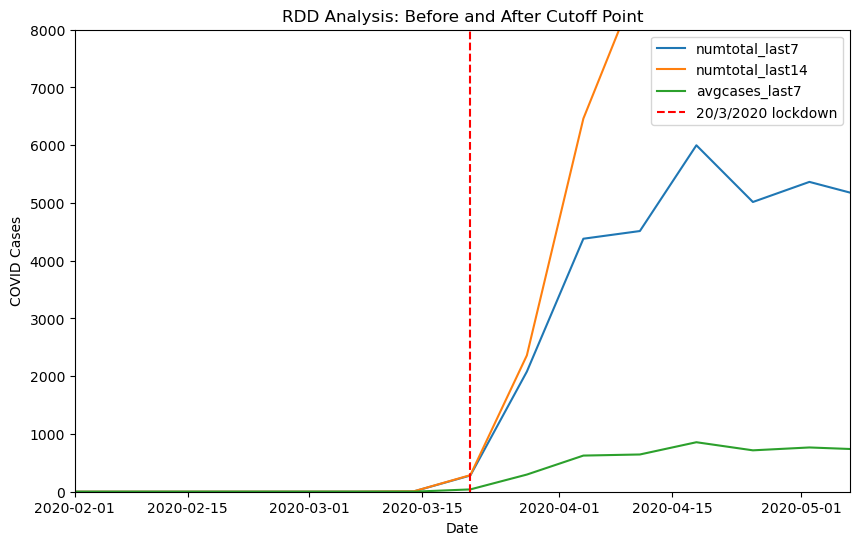

In [121]:
# ---------------------- RDD Plotting for lockdown_1 --------------------------
# Plot data
    # Create plot
plt.figure(figsize=(10, 6))
outcome_variables = ['numtotal_last7', 'numtotal_last14', 'avgcases_last7']
for outcome_variable in outcome_variables:
    plt.plot(df.index, df[outcome_variable], label=outcome_variable)

    # Add cutoff point
plt.axvline(x=df.index[df['lockdown_1'] == 1][0], color='red', linestyle='--', label='20/3/2020 lockdown')

    # Modify graph
plt.xlim(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-05-07'))
plt.ylim(0, 8000)
plt.xlabel('Date')
plt.ylabel('COVID Cases')
plt.title('RDD Analysis: Before and After Cutoff Point')
plt.legend()
plt.show()

In [108]:
#  -------------------------- RDD Regression for lockdown 1  --------------------------

# Define variables
outcome_variables = ['numtotal_last7', 'numtotal_last14', 'avgcases_last7']
predictors = ['lockdown_1']

# Filter time period
start_date = '2020-02-01'
end_date = '2020-05-07'
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

# Loop through each outcome variable
for outcome_variable in outcome_variables:
    X = sm.add_constant(filtered_df[predictors])

    # Fit OLS model
    model = sm.OLS(filtered_df[outcome_variable], X)
    results = model.fit()

    # Display results
    print(f"\nRegression results for {outcome_variable} (Date range: {start_date} to {end_date}):")
    print(results.summary())


Regression results for numtotal_last7 (Date range: 2020-02-01 to 2020-05-07):
                            OLS Regression Results                            
Dep. Variable:         numtotal_last7   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     26.38
Date:                Wed, 31 Jan 2024   Prob (F-statistic):           0.000246
Time:                        10:56:18   Log-Likelihood:                -120.58
No. Observations:                  14   AIC:                             245.2
Df Residuals:                      12   BIC:                             246.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

C:\Users\neila\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\neila\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\neila\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


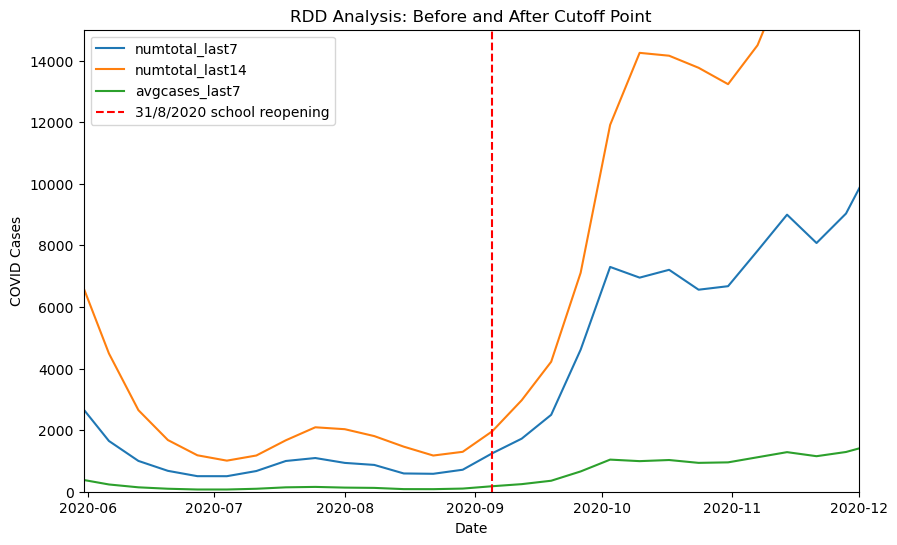

In [122]:
# ---------------------- RDD Plotting for school_reopening --------------------------
# Plot data
    # Create plot
plt.figure(figsize=(10, 6))
outcome_variables = ['numtotal_last7', 'numtotal_last14', 'avgcases_last7']
for outcome_variable in outcome_variables:
    plt.plot(df.index, df[outcome_variable], label=outcome_variable)

    # Add cutoff point
plt.axvline(x=df.index[df['school_reopening'] == 1][0], color='red', linestyle='--', label='31/8/2020 school reopening')

    # Modify graph
plt.xlim(pd.Timestamp('2020-05-31'), pd.Timestamp('2020-12-01'))
plt.ylim(0, 15000)
plt.xlabel('Date')
plt.ylabel('COVID Cases')
plt.title('RDD Analysis: Before and After Cutoff Point')
plt.legend()
plt.show()

In [92]:
#  -------------------------- RDD Regression for school_reopening  --------------------------

# Define variables
outcome_variables = ['numtotal_last7', 'numtotal_last14', 'avgcases_last7']
predictors = ['school_reopening']

# Filter time period
start_date = '2020-05-31'
end_date = '2020-12-01'
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

# Loop through each outcome variable
for outcome_variable in outcome_variables:
    X = sm.add_constant(filtered_df[predictors])

    # Fit OLS model
    model = sm.OLS(filtered_df[outcome_variable], X)
    results = model.fit()

    # Display results
    print(f"\nRegression results for {outcome_variable} (Date range: {start_date} to {end_date}):")
    print(results.summary())


Regression results for numtotal_last7 (Date range: 2020-05-31 to 2020-12-01):
                            OLS Regression Results                            
Dep. Variable:         numtotal_last7   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     49.00
Date:                Tue, 30 Jan 2024   Prob (F-statistic):           3.08e-07
Time:                        21:56:40   Log-Likelihood:                -232.17
No. Observations:                  26   AIC:                             468.3
Df Residuals:                      24   BIC:                             470.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

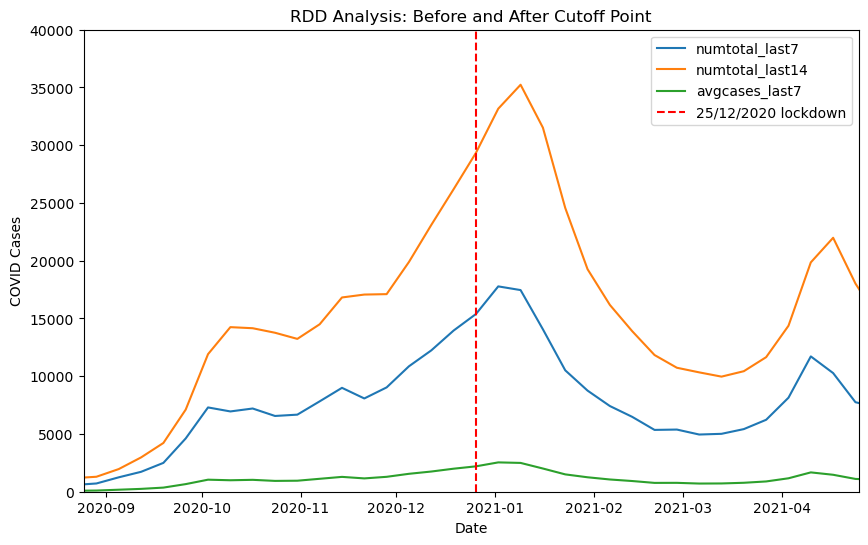

In [123]:
# ---------------------- RDD Plotting for lockdown_2 --------------------------
# Plot data
    # Create plot
plt.figure(figsize=(10, 6))
outcome_variables = ['numtotal_last7', 'numtotal_last14', 'avgcases_last7']
for outcome_variable in outcome_variables:
    plt.plot(df.index, df[outcome_variable], label=outcome_variable)

    # Add cutoff point
plt.axvline(x=df.index[df['lockdown_2'] == 1][0], color='red', linestyle='--', label='25/12/2020 lockdown')

    # Modify graph
plt.xlim(pd.Timestamp('2020-08-25'), pd.Timestamp('2021-04-25'))
plt.ylim(0, 40000)
plt.xlabel('Date')
plt.ylabel('COVID Cases')
plt.title('RDD Analysis: Before and After Cutoff Point')
plt.legend()
plt.show()

In [118]:
#  -------------------------- RDD Regression for lockdown_2  --------------------------
# Define variables
outcome_variables = ['numtotal_last7', 'numtotal_last14', 'avgcases_last7']
predictors = ['lockdown_2']

# Filter time period
start_date = '2020-08-25'
end_date = '2021-04-25'
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

# Loop through each outcome variable
for outcome_variable in outcome_variables:
    X = sm.add_constant(filtered_df[predictors])

    # Fit OLS model
    model = sm.OLS(filtered_df[outcome_variable], X)
    results = model.fit()

    # Display results
    print(f"\nRegression results for {outcome_variable} (Date range: {start_date} to {end_date}):")
    print(results.summary())


Regression results for numtotal_last7 (Date range: 2020-08-25 to 2021-04-25):
                            OLS Regression Results                            
Dep. Variable:         numtotal_last7   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3.294
Date:                Wed, 31 Jan 2024   Prob (F-statistic):             0.0786
Time:                        11:55:35   Log-Likelihood:                -339.37
No. Observations:                  35   AIC:                             682.7
Df Residuals:                      33   BIC:                             685.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

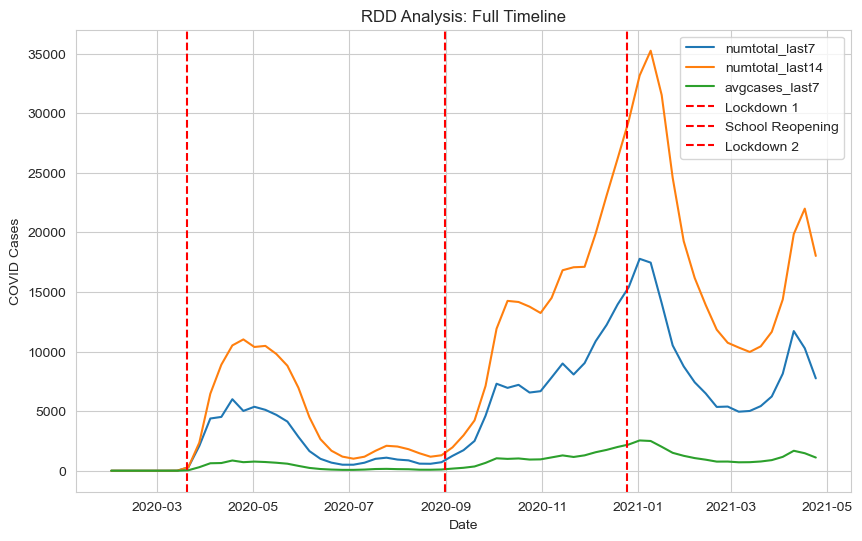

In [127]:
#  -------------------------- Full timeline plot  --------------------------
# Define variables
outcome_variables = ['numtotal_last7', 'numtotal_last14', 'avgcases_last7']
predictors = ['lockdown_1', 'school_reopening', 'lockdown_2']

# Filter time period
start_date = '2020-02-01'
end_date = '2021-04-25'
filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

# Plot setup
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Loop through each outcome variable
for outcome_variable in outcome_variables:
    plt.plot(filtered_df.index, filtered_df[outcome_variable], label=outcome_variable)

# Add vertical lines for each event
events = [lockdown_1, school_reopening, lockdown_2]
event_labels = ['Lockdown 1', 'School Reopening', 'Lockdown 2']

for event, label in zip(events, event_labels):
    plt.axvline(x=event, color='red', linestyle='--', label=label)

# Customize the plot
plt.title('RDD Analysis: Full Timeline')
plt.xlabel('Date')
plt.ylabel('COVID Cases')
plt.legend()
plt.show()
